In [8]:
import logging
logging.basicConfig(level=logging.INFO)

import sys
sys.path.insert(0, "/home/laadd/DDP/B-SOID/")
import random
import numpy as np
import seaborn as sns

from itertools import combinations

from BSOID.bsoid import *
from BSOID.preprocessing import *

from behavelet import wavelet_transform

%matplotlib notebook

In [10]:
import psutil
from psutil._common import bytes2human

print(bytes2human(psutil.virtual_memory().free))
num_cpus = psutil.cpu_count(logical=False)
print(num_cpus)

149.0G
18


In [11]:
def embed_data(data, n_components, scale, **umap_params):
    if scale:
        data = StandardScaler().fit_transform(data)
    embed = umap.UMAP(n_components=n_components, **umap_params).fit_transform(data)
    return embed

def cluster_data(data, cluster_range, **hdbscan_params):
    labels, _, soft_labels, clusterer = cluster_with_hdbscan(data, cluster_range, hdbscan_params)
    print(f"Entropy Ratio: {calculate_entropy_ratio(soft_labels)}")
    return labels, soft_labels, clusterer

def calculate_entropy_ratio(labels):
    idxs, counts = np.unique(labels, return_counts=True)
    prop = [x / counts.sum() for x in counts]    
    return -sum(p * np.log2(p) for p in prop) / max_entropy(labels.max() + 1)

def pca_reduced_dim(data, var, scale):
    if scale:
        data = StandardScaler().fit_transform(data)
    pca = PCA().fit(data)
    return np.where(np.cumsum(pca.explained_variance_ratio_) >= var)[0][0] + 1

def plot(X, **kwargs):
    plt.scatter(X[:,0], X[:,1], **kwargs)
    plt.show()

In [12]:
def extract_dis_feats(filtered_data, fps, stride_window):
    """
    0-6 : lenghts ofW 7 body links
    7-14 : magnitude of displacements for all 8 points
    14-21 : displacement angles for links 
    """
    x_raw, y_raw = filtered_data['x'], filtered_data['y']

    assert x_raw.shape == y_raw.shape
    N, n_dpoints = x_raw.shape

    win_len = np.int(np.round(0.05 / (1 / fps)) * 2 - 1) if stride_window is None else stride_window // 2
    logging.debug('feature extraction from {} samples of {} points with {} ms smoothing window'.format(*x_raw.shape, round(win_len * 1000 / 30)))
    
    x, y = np.zeros_like(x_raw), np.zeros_like(y_raw)
    for i in range(x.shape[1]):
        x[:,i] = smoothen_data(x_raw[:,i], win_len)
        y[:,i] = smoothen_data(y_raw[:,i], win_len)

    # indices -> features
    HEAD, BASE_NECK, CENTER_SPINE, HINDPAW1, HINDPAW2, BASE_TAIL, MID_TAIL, TIP_TAIL = np.arange(8)

    # link connections [start, end]
    link_connections = ([BASE_TAIL, CENTER_SPINE],
                        [CENTER_SPINE, BASE_NECK],
                        [BASE_NECK, HEAD],
                        [BASE_TAIL, HINDPAW1], [BASE_TAIL, HINDPAW2],
                        [BASE_TAIL, MID_TAIL],
                        [MID_TAIL, TIP_TAIL])

    # displacement of points
    dis = np.array([x[1:,:] - x[0:N-1,:], y[1:,:] - y[0:N-1,:]])
    dis = np.linalg.norm(dis, axis=0)

    # links
    links = []
    for conn in link_connections:
        links.append(np.array([x[:, conn[0]] - x[:, conn[1]], y[:, conn[0]] - y[:, conn[1]]]).T)    

    # link lengths
    link_lens = np.vstack([np.linalg.norm(link, axis=1) for link in links]).T

    # angles between link position for consecutive timesteps
    angles = []
    for link in links:
        curr_angles = []
        for k in range(N-1):
            link_dis_cross = np.cross(link[k], link[k+1])
            curr_angles.append(math.atan2(link_dis_cross, link[k].dot(link[k+1])))
        angles.append(np.array(curr_angles))
    angles = np.vstack(angles).T
    
    feats = np.hstack((link_lens[1:], dis, angles))
    
    win_feats = []
    win_feats.append(windowed_feats(feats[:,:7], stride_window, mode='mean'))
    win_feats.append(windowed_feats(feats[:,7:22], stride_window, mode='sum'))
    win_feats = np.hstack(win_feats)

    return win_feats
    
def head_average(fdata):
    for data in fdata:
        data['x'] = np.hstack((data['x'][:,:3].mean(axis=1).reshape(-1,1), data['x'][:,3:]))
        data['y'] = np.hstack((data['y'][:,:3].mean(axis=1).reshape(-1,1), data['y'][:,3:]))
    return fdata

def temporal(data, **kwargs):
    wav = wavelet_transform(data, n_jobs=psutil.cpu_count(logical=False), **kwargs)
    return wav
    
def strided_subsample(data, stride_window):
    return data[stride_window:-1:stride_window]

In [64]:
def pipeline(animal):
    strain = "C57BL/6J"
    
    bsoid = BSOID("../config/config.yaml")
    fdata = bsoid.load_filtered_data()
    fdata = fdata[strain]
    
    fdata = head_average(fdata)
    
    def extract(data, fps, stride_window):
        x, y = data['x'], data['y']
        N, n_dpoints = x.shape
        
        win_len = np.int(np.round(0.05 / (1 / fps)) * 2 - 1)
        
        links = [np.array([x[:,i] - x[:,j], y[:,i] - y[:,j]]).T for i, j in combinations(range(n_dpoints), 2)]
        ll = np.vstack([np.linalg.norm(link, axis=1) for link in links]).T
#         ll_disp = ll[1:] - ll[:N-1]
        disp = np.linalg.norm(np.array([x[1:,:] - x[0:N-1,:], y[1:,:] - y[0:N-1,:]]), axis=0)
        ll_disp_th = np.vstack([np.arctan2(np.cross(link[0:N-1], link[1:]), np.sum(link[0:N-1] * link[1:], axis=1)) for link in links]).T
#         link_angles = np.vstack([np.arctan2(link[:,1], link[:,0]) for link in links]).T
        
        for i in range(ll.shape[1]):
            ll[:,i] = smoothen_data(ll[:,i], win_len)
            ll_disp_th[:,i] = smoothen_data(ll_disp_th[:,i], win_len)
#             link_angles[:,i] = smoothen_data(link_angles[:,i], win_len)
        for i in range(disp.shape[1]):
            disp[:,i] = smoothen_data(disp[:,i], win_len)
        
        
        if stride_window >= 3:
            ll = windowed_feats(ll, stride_window, mode="mean")
            disp = windowed_feats(disp, stride_window, mode="sum")
            ll_disp_th = windowed_feats(ll_disp_th, stride_window, mode="sum")
#             link_angles = windowed_feats(link_angles, stride_window, mode="sum")
        else:
            ll = ll[1:]
        
        return np.hstack((ll, ll_disp_th))
#         return ll
    
#     stride_window = int(input("Stride Window: "))
#     feats = Parallel(n_jobs=num_cpus)(delayed(extract)(data, bsoid.fps, stride_window) for data in fdata)
#     feats = extract(random.sample(fdata, 1)[0], bsoid.fps, stride_window)
    feats = extract(fdata[animal], bsoid.fps, -1)
    feats = np.vstack(feats)
    print((f"Raw Dataset Size: {feats.shape}"))
#     num_points = int(input("Subsample: "))
    num_points = -1
    if num_points > 0:
        feats = np.random.permutation(feats)[:num_points]

#     feats = wavelet_transform(feats, n_jobs=psutil.cpu_count(logical=False), n_freqs=25, fmin=0.15, fmax=15, fsample=30)[2]
    print(f"PCA: {pca_reduced_dim(feats, 0.9, scale=True)}")
    
    print((f"Dataset size: {feats.shape}"))
    embedding = embed_data(feats, n_components=20, scale=True, n_neighbors=60, min_dist=0.0, metric="cosine", verbose=False)
    labels, soft_labels, _ = cluster_data(embedding, [0.4, 1.2, 9], **bsoid.hdbscan_params)
    
    return feats, embedding, soft_labels, labels

In [66]:
for i in range(10):
    feats, embedding, slabels, labels = pipeline(i)

    Run ID       : dis
 Save Location   : /home/laadd/data/bsoid_data/dis/output
      FPS        : 30
 Min. Confidence : 0.3
  Stride Window  : 333ms

Raw Dataset Size: (53999, 56)
PCA: 14
Dataset size: (53999, 56)


INFO:root:identified 13 clusters (max is 13) with min_sample_prop=0.4 and entropy_ratio=0.364
INFO:root:identified 11 clusters (max is 13) with min_sample_prop=0.5 and entropy_ratio=0.386
INFO:root:identified 11 clusters (max is 13) with min_sample_prop=0.6 and entropy_ratio=0.386
INFO:root:identified 11 clusters (max is 13) with min_sample_prop=0.7 and entropy_ratio=0.386
INFO:root:identified 11 clusters (max is 13) with min_sample_prop=0.8 and entropy_ratio=0.386
INFO:root:identified 11 clusters (max is 13) with min_sample_prop=0.9 and entropy_ratio=0.386
INFO:root:identified 11 clusters (max is 13) with min_sample_prop=1.0 and entropy_ratio=0.386
INFO:root:identified 8 clusters (max is 13) with min_sample_prop=1.1 and entropy_ratio=0.392
INFO:root:identified 4 clusters (max is 13) with min_sample_prop=1.2 and entropy_ratio=0.485


Entropy Ratio: 0.3867107128170828
    Run ID       : dis
 Save Location   : /home/laadd/data/bsoid_data/dis/output
      FPS        : 30
 Min. Confidence : 0.3
  Stride Window  : 333ms

Raw Dataset Size: (53999, 56)
PCA: 13
Dataset size: (53999, 56)


INFO:root:identified 5 clusters (max is 5) with min_sample_prop=0.4 and entropy_ratio=0.18
INFO:root:identified 4 clusters (max is 5) with min_sample_prop=0.5 and entropy_ratio=0.19
INFO:root:identified 3 clusters (max is 5) with min_sample_prop=0.6 and entropy_ratio=0.207
INFO:root:identified 3 clusters (max is 5) with min_sample_prop=0.7 and entropy_ratio=0.207
INFO:root:identified 3 clusters (max is 5) with min_sample_prop=0.8 and entropy_ratio=0.207
INFO:root:identified 3 clusters (max is 5) with min_sample_prop=0.9 and entropy_ratio=0.207
INFO:root:identified 3 clusters (max is 5) with min_sample_prop=1.0 and entropy_ratio=0.207
INFO:root:identified 3 clusters (max is 5) with min_sample_prop=1.1 and entropy_ratio=0.207
INFO:root:identified 3 clusters (max is 5) with min_sample_prop=1.2 and entropy_ratio=0.207


Entropy Ratio: 0.18146557488129794
    Run ID       : dis
 Save Location   : /home/laadd/data/bsoid_data/dis/output
      FPS        : 30
 Min. Confidence : 0.3
  Stride Window  : 333ms

Raw Dataset Size: (53999, 56)
PCA: 14
Dataset size: (53999, 56)


INFO:root:identified 8 clusters (max is 8) with min_sample_prop=0.4 and entropy_ratio=0.116
INFO:root:identified 16 clusters (max is 16) with min_sample_prop=0.5 and entropy_ratio=0.32
INFO:root:identified 3 clusters (max is 16) with min_sample_prop=0.6 and entropy_ratio=0.073
INFO:root:identified 8 clusters (max is 16) with min_sample_prop=0.7 and entropy_ratio=0.289
INFO:root:identified 7 clusters (max is 16) with min_sample_prop=0.8 and entropy_ratio=0.285
INFO:root:identified 6 clusters (max is 16) with min_sample_prop=0.9 and entropy_ratio=0.279
INFO:root:identified 5 clusters (max is 16) with min_sample_prop=1.0 and entropy_ratio=0.301
INFO:root:identified 4 clusters (max is 16) with min_sample_prop=1.1 and entropy_ratio=0.303
INFO:root:identified 4 clusters (max is 16) with min_sample_prop=1.2 and entropy_ratio=0.303


Entropy Ratio: 0.3760984829293738
    Run ID       : dis
 Save Location   : /home/laadd/data/bsoid_data/dis/output
      FPS        : 30
 Min. Confidence : 0.3
  Stride Window  : 333ms

Raw Dataset Size: (53999, 56)
PCA: 21
Dataset size: (53999, 56)


INFO:root:identified 40 clusters (max is 40) with min_sample_prop=0.4 and entropy_ratio=0.612
INFO:root:identified 33 clusters (max is 40) with min_sample_prop=0.5 and entropy_ratio=0.617
INFO:root:identified 26 clusters (max is 40) with min_sample_prop=0.6 and entropy_ratio=0.602
INFO:root:identified 21 clusters (max is 40) with min_sample_prop=0.7 and entropy_ratio=0.615
INFO:root:identified 9 clusters (max is 40) with min_sample_prop=0.8 and entropy_ratio=0.306
INFO:root:identified 7 clusters (max is 40) with min_sample_prop=0.9 and entropy_ratio=0.318
INFO:root:identified 5 clusters (max is 40) with min_sample_prop=1.0 and entropy_ratio=0.374
INFO:root:identified 5 clusters (max is 40) with min_sample_prop=1.1 and entropy_ratio=0.374
INFO:root:identified 4 clusters (max is 40) with min_sample_prop=1.2 and entropy_ratio=0.393


Entropy Ratio: 0.6594729240636897
    Run ID       : dis
 Save Location   : /home/laadd/data/bsoid_data/dis/output
      FPS        : 30
 Min. Confidence : 0.3
  Stride Window  : 333ms

Raw Dataset Size: (53999, 56)
PCA: 13
Dataset size: (53999, 56)


INFO:root:identified 2 clusters (max is 2) with min_sample_prop=0.4 and entropy_ratio=0.063
INFO:root:identified 2 clusters (max is 2) with min_sample_prop=0.5 and entropy_ratio=0.063
INFO:root:identified 2 clusters (max is 2) with min_sample_prop=0.6 and entropy_ratio=0.063
INFO:root:identified 2 clusters (max is 2) with min_sample_prop=0.7 and entropy_ratio=0.063
INFO:root:identified 2 clusters (max is 2) with min_sample_prop=0.8 and entropy_ratio=0.078
INFO:root:identified 2 clusters (max is 2) with min_sample_prop=0.9 and entropy_ratio=0.078
INFO:root:identified 2 clusters (max is 2) with min_sample_prop=1.0 and entropy_ratio=0.095
INFO:root:identified 2 clusters (max is 2) with min_sample_prop=1.1 and entropy_ratio=0.095
INFO:root:identified 2 clusters (max is 2) with min_sample_prop=1.2 and entropy_ratio=0.231


Entropy Ratio: 0.25347653751806126
    Run ID       : dis
 Save Location   : /home/laadd/data/bsoid_data/dis/output
      FPS        : 30
 Min. Confidence : 0.3
  Stride Window  : 333ms

Raw Dataset Size: (53999, 56)
PCA: 17
Dataset size: (53999, 56)


INFO:root:identified 45 clusters (max is 45) with min_sample_prop=0.4 and entropy_ratio=0.918
INFO:root:identified 11 clusters (max is 45) with min_sample_prop=0.5 and entropy_ratio=0.33
INFO:root:identified 9 clusters (max is 45) with min_sample_prop=0.6 and entropy_ratio=0.335
INFO:root:identified 8 clusters (max is 45) with min_sample_prop=0.7 and entropy_ratio=0.347
INFO:root:identified 8 clusters (max is 45) with min_sample_prop=0.8 and entropy_ratio=0.347
INFO:root:identified 8 clusters (max is 45) with min_sample_prop=0.9 and entropy_ratio=0.347
INFO:root:identified 6 clusters (max is 45) with min_sample_prop=1.0 and entropy_ratio=0.387
INFO:root:identified 6 clusters (max is 45) with min_sample_prop=1.1 and entropy_ratio=0.387
INFO:root:identified 6 clusters (max is 45) with min_sample_prop=1.2 and entropy_ratio=0.387


Entropy Ratio: 0.9287561156567065
    Run ID       : dis
 Save Location   : /home/laadd/data/bsoid_data/dis/output
      FPS        : 30
 Min. Confidence : 0.3
  Stride Window  : 333ms

Raw Dataset Size: (53999, 56)
PCA: 15
Dataset size: (53999, 56)


INFO:root:identified 4 clusters (max is 4) with min_sample_prop=0.4 and entropy_ratio=0.132
INFO:root:identified 2 clusters (max is 4) with min_sample_prop=0.5 and entropy_ratio=0.219
INFO:root:identified 2 clusters (max is 4) with min_sample_prop=0.6 and entropy_ratio=0.219
INFO:root:identified 2 clusters (max is 4) with min_sample_prop=0.7 and entropy_ratio=0.219
INFO:root:identified 2 clusters (max is 4) with min_sample_prop=0.8 and entropy_ratio=0.219
INFO:root:identified 2 clusters (max is 4) with min_sample_prop=0.9 and entropy_ratio=0.219
INFO:root:identified 2 clusters (max is 4) with min_sample_prop=1.0 and entropy_ratio=0.219
INFO:root:identified 2 clusters (max is 4) with min_sample_prop=1.1 and entropy_ratio=0.219
INFO:root:identified 2 clusters (max is 4) with min_sample_prop=1.2 and entropy_ratio=0.219


Entropy Ratio: 0.14481745313344732
    Run ID       : dis
 Save Location   : /home/laadd/data/bsoid_data/dis/output
      FPS        : 30
 Min. Confidence : 0.3
  Stride Window  : 333ms

Raw Dataset Size: (53999, 56)
PCA: 15
Dataset size: (53999, 56)


INFO:root:identified 24 clusters (max is 24) with min_sample_prop=0.4 and entropy_ratio=0.472
INFO:root:identified 21 clusters (max is 24) with min_sample_prop=0.5 and entropy_ratio=0.476
INFO:root:identified 17 clusters (max is 24) with min_sample_prop=0.6 and entropy_ratio=0.494
INFO:root:identified 15 clusters (max is 24) with min_sample_prop=0.7 and entropy_ratio=0.489
INFO:root:identified 12 clusters (max is 24) with min_sample_prop=0.8 and entropy_ratio=0.5
INFO:root:identified 11 clusters (max is 24) with min_sample_prop=0.9 and entropy_ratio=0.514
INFO:root:identified 11 clusters (max is 24) with min_sample_prop=1.0 and entropy_ratio=0.514
INFO:root:identified 11 clusters (max is 24) with min_sample_prop=1.1 and entropy_ratio=0.514
INFO:root:identified 11 clusters (max is 24) with min_sample_prop=1.2 and entropy_ratio=0.514


Entropy Ratio: 0.504827390531072
    Run ID       : dis
 Save Location   : /home/laadd/data/bsoid_data/dis/output
      FPS        : 30
 Min. Confidence : 0.3
  Stride Window  : 333ms

Raw Dataset Size: (53999, 56)
PCA: 15
Dataset size: (53999, 56)


INFO:root:identified 10 clusters (max is 10) with min_sample_prop=0.4 and entropy_ratio=0.26
INFO:root:identified 9 clusters (max is 10) with min_sample_prop=0.5 and entropy_ratio=0.267
INFO:root:identified 9 clusters (max is 10) with min_sample_prop=0.6 and entropy_ratio=0.267
INFO:root:identified 8 clusters (max is 10) with min_sample_prop=0.7 and entropy_ratio=0.277
INFO:root:identified 7 clusters (max is 10) with min_sample_prop=0.8 and entropy_ratio=0.288
INFO:root:identified 7 clusters (max is 10) with min_sample_prop=0.9 and entropy_ratio=0.288
INFO:root:identified 5 clusters (max is 10) with min_sample_prop=1.0 and entropy_ratio=0.286
INFO:root:identified 5 clusters (max is 10) with min_sample_prop=1.1 and entropy_ratio=0.286
INFO:root:identified 5 clusters (max is 10) with min_sample_prop=1.2 and entropy_ratio=0.286


Entropy Ratio: 0.2642640102013085
    Run ID       : dis
 Save Location   : /home/laadd/data/bsoid_data/dis/output
      FPS        : 30
 Min. Confidence : 0.3
  Stride Window  : 333ms

Raw Dataset Size: (53999, 56)
PCA: 13
Dataset size: (53999, 56)


INFO:root:identified 4 clusters (max is 4) with min_sample_prop=0.4 and entropy_ratio=0.085
INFO:root:identified 3 clusters (max is 4) with min_sample_prop=0.5 and entropy_ratio=0.078
INFO:root:identified 3 clusters (max is 4) with min_sample_prop=0.6 and entropy_ratio=0.078
INFO:root:identified 2 clusters (max is 4) with min_sample_prop=0.7 and entropy_ratio=0.071
INFO:root:identified 2 clusters (max is 4) with min_sample_prop=0.8 and entropy_ratio=0.071
INFO:root:identified 19 clusters (max is 19) with min_sample_prop=0.9 and entropy_ratio=0.93
INFO:root:identified 17 clusters (max is 19) with min_sample_prop=1.0 and entropy_ratio=0.934
INFO:root:identified 9 clusters (max is 19) with min_sample_prop=1.1 and entropy_ratio=0.471
INFO:root:identified 8 clusters (max is 19) with min_sample_prop=1.2 and entropy_ratio=0.464


Entropy Ratio: 0.9462331522235736


<IPython.core.display.Javascript object>


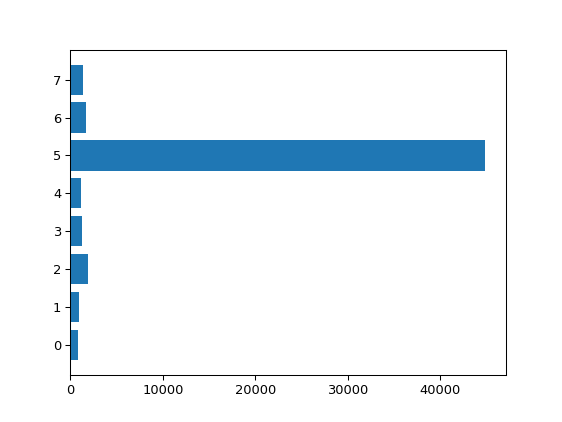

In [41]:
idxs, counts = np.unique(slabels, return_counts=True)
plt.barh(idxs, counts)
plt.show()

In [36]:
vis_embed = embed_data(feats, n_components=2, scale=True, min_dist=0.0, n_neighbors=30, metric="euclidean", verbose=True)
plot(vis_embed, c=soft_labels, s=0.1, cmap="terrain")

UMAP(min_dist=0.0, n_neighbors=30, verbose=True)
Construct fuzzy simplicial set
Fri May 14 22:55:30 2021 Finding Nearest Neighbors
Fri May 14 22:55:30 2021 Building RP forest with 17 trees
Fri May 14 22:55:31 2021 NN descent for 16 iterations


KeyboardInterrupt: 

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
model = RandomForestClassifier(n_jobs=-1)

In [38]:
cross_validate(model, feats, slabels, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring=["accuracy", "balanced_accuracy"], error_score="raise")

{'fit_time': array([5.92662954, 2.07069421, 2.01375747, 2.04507303, 1.99365687]),
 'score_time': array([0.13283086, 0.12687421, 0.12672234, 0.12614918, 0.12928271]),
 'test_accuracy': array([0.98564815, 0.98722222, 0.98537037, 0.98666667, 0.98740624]),
 'test_balanced_accuracy': array([0.93893098, 0.95192239, 0.94535333, 0.94226084, 0.94901468])}

In [39]:
model.fit(feats, slabels)
with open("/fastscratch/laadd/test.model", "wb") as f:
    joblib.dump(model, f)

In [18]:
feats.shape

(53999, 1400)